The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


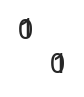

In [124]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import itertools
from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

# init

In [128]:
bench = pd.read_csv('../../benchmark/230516_final_bench_newnnalign.csv')
concat = pd.read_csv('../../benchmark/230516_final_concatgb_newnnalign.csv')
pivot_gb = pd.read_csv('../../benchmark/230516_final_pivotgb_newnnalign.csv')


def add_vertical_label(df, order, column, axis, height=None, fontsize=12, fontweight='semibold'):
    
    tmp = df.groupby(['Model']).agg(mean=(column, 'mean'), std = (column, 'std')).reindex(order)
    xs = range(len(order))
    values = tmp['mean'].values.flatten()
    
    stds = tmp['std'].values.flatten()
    ys = values /2
    
    for i, (x, y, value, std) in enumerate(zip(xs, ys, values, stds)):
        # c = 'k' if i < len(xs)//2 else 'w'
        c='k'
        # height = value+2*std 
        height = y if height is None else height
        axis.text(x, height, f'{value:.3f}\n± {std:.3f}', ha='center', va='center',
                  fontweight=fontweight, fontsize=fontsize, color=c)
    
    
def add_horizontal_label(df, order, column, axis, length=None, fontsize=12, fontweight='semibold'):
    tmp = df.reindex(order)
    ys = range(len(order))
    values = tmp[f'mean_{column}'].values.flatten()
    stds = tmp[f'std_{column}'].values.flatten()
    xs = values / 2
    
    for i, (x, y, value, std) in enumerate(zip(xs, ys, values, stds)):
        
        length = x if length is None else length
        # c = 'k' if i< len(ys)//2 else 'w'
        c = 'k'
        axis.text(length, y, f'{value:.3f}\n± {std:.3f}', ha='center', va='center', 
                  fontweight=fontweight, fontsize=fontsize, color=c)
        
def merge_2axes(fig1,fig2,file_name1="f1.png",file_name2="f2.png", dpi=200, pad=.1,
                final_fn = '../../../writing/230131_cedar_paper_1/figures/230517_Final_benchmark_figure_merged.png'):
    custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False, "axes.spines.bottom": False}
    sns.set_theme(style="ticks", rc=custom_params)
    fig1.savefig(file_name1, bbox_inches='tight', dpi= dpi)
    fig2.savefig(file_name2, bbox_inches='tight', dpi= dpi)
    
    # inherit figures' dimensions, partially
    h1, h2 = [int(np.ceil(fig.get_figheight())) for fig in (fig1, fig2)]
    wmax = int(np.ceil(max([fig.get_figwidth() for fig in (fig1, fig2)])))

    fig, axes = plt.subplots(h1 + h2, figsize=(wmax, h1 + h2))
    
    # make two axes of desired height proportion
    gs = axes[0].get_gridspec()
    for ax in axes.flat:
        ax.remove()
    ax1 = fig.add_subplot(gs[:h1])
    ax2 = fig.add_subplot(gs[h1:])
    fig.subplots_adjust(wspace=0)

    ax1.imshow(plt.imread(file_name1))
    ax2.imshow(plt.imread(file_name2))

    for ax in (ax1, ax2):
        for side in ('top', 'left', 'bottom', 'right'):
            ax.spines[side].set_visible(False)
            ax.tick_params(left=False, right=False, labelleft=False,
                     labelbottom=False, bottom=False)
    fig.tight_layout(pad=pad)
    fig.savefig(final_fn, dpi=dpi, bbox_inches='tight')
    sns.set_style('darkgrid')
    return fig 

In [129]:
bench.query('Model=="NNAlign"').groupby(['evalset']).agg(mean_auc = ('auc','mean'))

,mean_auc
evalset,
CEDAR,0.690832
NEPDB,0.439125
PRIME,0.693658


In [130]:
bench.query('Model=="Harmonic Model"').groupby(['evalset']).agg(mean_auc = ('auc','mean'))

,mean_auc
evalset,
CEDAR,0.718216
NEPDB,0.803688
PRIME,0.720788


In [131]:
bench.replace({'Base Model' : 'Baseline', 'Harmonic Model' :'ICERFIRE'},inplace=True)
bench.groupby(['Model']).agg(count=('auc','count'))

,count
Model,
AXEL-F,30000
Baseline,30000
HLAthena_E,30000
ICERFIRE,30000
IEDB-Calis,30000
MHCflurry,30000
NNAlign,30000
NetMHCpan,30000
NetMHCpanExp,30000


# Retrain base model (AA+%Rank) Icore vs fullpep

In [42]:
cedar = pd.read_csv('../data/aligned_icore/230418_cedar_aligned.csv')
[x for x in cedar.columns if 'rank' in x]

['EL_rank_mut',
 'EL_rank_wt',
 'trueHLA_EL_rank',
 'EL_rank_wt_aligned',
 'ratio_rank',
 'fullpep_vs_icore_rank',
 'mixed_rank_0_1',
 'mixed_rank_binder_0_1',
 'mixed_rank_0_25',
 'mixed_rank_binder_0_25',
 'mixed_rank_0_5',
 'mixed_rank_binder_0_5',
 'mixed_rank_0_75',
 'mixed_rank_binder_0_75',
 'mixed_rank_1',
 'mixed_rank_binder_1']

In [50]:
from sklearn.ensemble import RandomForestClassifier
from src.metrics import get_metrics
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn

invert, ic_name, ics_dict, mask = (False, 'None', None, False)
cedar = pd.read_csv('../data/aligned_icore/230418_cedar_aligned.csv')
encoding_kwargs = {'max_len': 12,
                       'encoding': 'onehot',
                       'blosum_matrix': None,
                       'mask': False,
                       'invert':False, 
                       'add_rank': True,
                       'hla_col': 'HLA',
                       'add_aaprop': False,
                       'remove_pep': False,
                       'standardize': True}

results = {}
for x in [('Peptide', 'trueHLA_EL_rank', 'FullPep + Pep%Rank'), ('icore_mut', 'EL_rank_mut', 'optICORE + optICORE %Rank')]:
    seq_col, rank_col, name = x
    encoding_kwargs['seq_col']=seq_col
    encoding_kwargs['rank_col']=rank_col
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                   max_depth=8, ccp_alpha=9.945e-6)
    # Training model and getting feature importances
    print('Training')
    trained_models, _, _ = nested_kcv_train_sklearn(cedar, model,
                                                    ics_dict=ics_dict,
                                                    encoding_kwargs=encoding_kwargs,
                                                    n_jobs=8)
    _, preds = evaluate_trained_models_sklearn(cedar,
                                               trained_models, ics_dict,
                                               cedar,
                                               encoding_kwargs, concatenated=False,
                                               only_concat=False, n_jobs=8, kcv_eval=True)
    p_col = 'pred' if 'pred' in preds.columns else 'mean_pred'
    metrics = get_metrics(preds['agg_label'].values, preds[p_col].values, reduced=False, threshold=0.16)
    
    results[name] = metrics

Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

In [51]:
results['optICORE + optICORE %Rank']

{'roc_curve': (array([0.        , 0.        , 0.        , ..., 0.99750208, 0.99750208,
         1.        ]),
  array([0.        , 0.00158479, 0.00316957, ..., 0.99841521, 1.        ,
         1.        ])),
 'pr_curve': (array([1.        , 1.        , 1.        , ..., 0.00316957, 0.00158479,
         0.        ]),
  array([0.20804484, 0.20811346, 0.20818212, ..., 1.        , 1.        ,
         1.        ])),
 'auc': 0.7136274446413514,
 'prauc': 0.4074035949907546,
 'AP': 0.40849893561188244,
 'auc_01': 0.5775825314198298,
 'f1': 0.4185126582278481,
 'accuracy': 0.5153313550939663,
 'precision': 0.2788613600421718,
 'recall': 0.838351822503962}

In [52]:
results['FullPep + Pep%Rank']
results['optICORE + optICORE %Rank']

{'roc_curve': (array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.32639467e-04,
         8.32639467e-04, 1.24895920e-03, 1.24895920e-03, 2.08159867e-03,
         2.08159867e-03, 2.49791840e-03, 2.49791840e-03, 4.16319734e-03,
         4.16319734e-03, 4.57951707e-03, 4.57951707e-03, 5.82847627e-03,
         5.82847627e-03, 6.24479600e-03, 6.24479600e-03, 7.07743547e-03,
         7.07743547e-03, 7.49375520e-03, 7.49375520e-03, 8.32639467e-03,
         8.32639467e-03, 8.74271440e-03, 8.74271440e-03, 9.57535387e-03,
         9.57535387e-03, 1.08243131e-02, 1.08243131e-02, 1.12406328e-02,
         1.12406328e-02, 1.16569525e-02, 1.16569525e-02, 1.20732723e-02,
         1.20732723e-02, 1.29059117e-02, 1.29059117e-02, 1.41548709e-02,
         1.41548709e-02, 1.45711907e-02, 1.45711907e-02, 1.49875104e-02,
         1.49875104e-02, 1.54038301e-02, 1.54038301e-02, 1.58201499e-02,
         1.58201499e-02, 1.66527893e-02, 1.66527893e-02, 1.74854288e-02,
         1.74854288e-02, 1.79017485e-0

# Redo some figures 

## roc

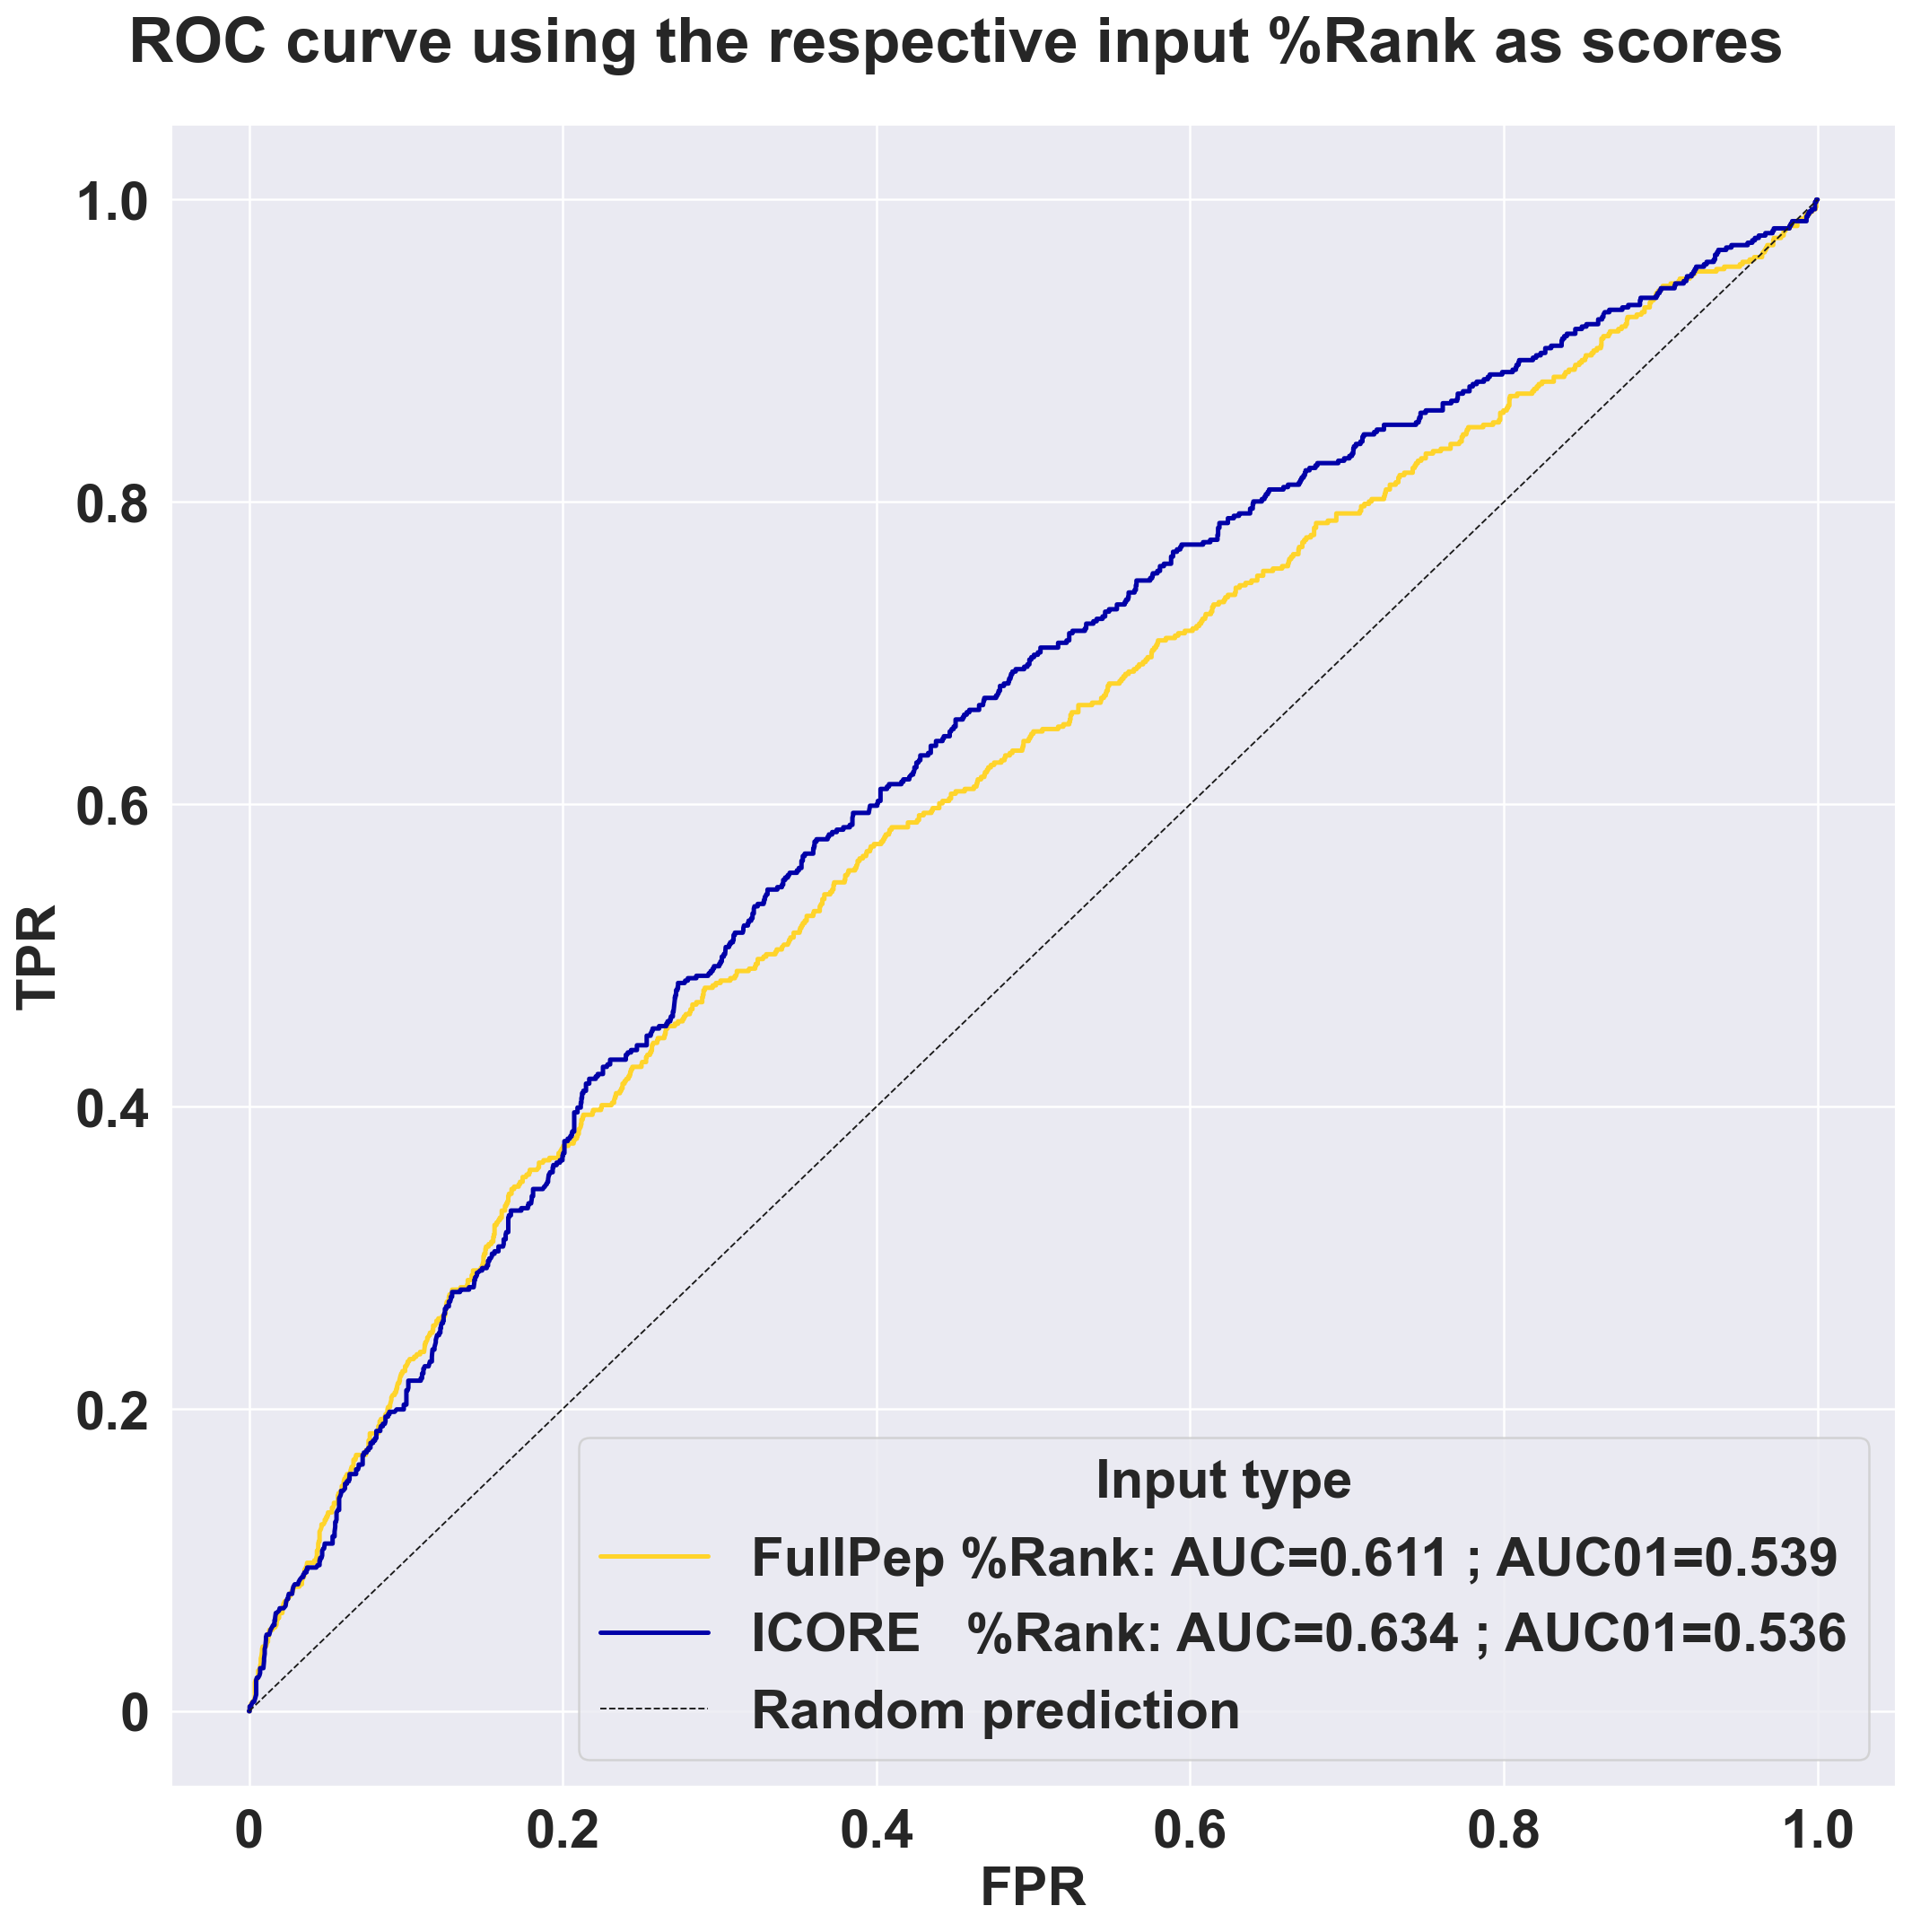

In [37]:
### ROC curve fig using fullpep rank vs icore rank
from sklearn.metrics import roc_auc_score, roc_curve
cedar_aligned = pd.read_csv('../data/aligned_icore/230418_cedar_aligned.csv')
f,a = plt.subplots(1,1, figsize=(12,12))
sns.set_style('darkgrid')
sns.set_palette(get_palette('gnuplot2_r', 2))
fpr_pep, tpr_pep, _ = roc_curve(cedar_aligned['agg_label'], 1-cedar_aligned['trueHLA_EL_rank'])
fpr_ic, tpr_ic, _ = roc_curve(cedar_aligned['agg_label'], 1-cedar_aligned['EL_rank_mut'])

auc_pep, auc01_pep = roc_auc_score(cedar_aligned['agg_label'], 1-cedar_aligned['trueHLA_EL_rank']), roc_auc_score(cedar_aligned['agg_label'], 1-cedar_aligned['trueHLA_EL_rank'], max_fpr=0.1)
auc_ic, auc01_ic = roc_auc_score(cedar_aligned['agg_label'], 1-cedar_aligned['EL_rank_mut']), roc_auc_score(cedar_aligned['agg_label'], 1-cedar_aligned['EL_rank_mut'], max_fpr=0.1)

sns.lineplot(x=fpr_pep, y=tpr_pep, estimator=None, lw=2, 
             label=f'FullPep %Rank: AUC={auc_pep:.3f} ; AUC01={auc01_pep:.3f}', ax=a)
sns.lineplot(x=fpr_ic, y=tpr_ic, estimator=None, lw=2, 
             label=f'ICORE   %Rank: AUC={auc_ic:.3f} ; AUC01={auc01_ic:.3f}', ax=a)
a.plot([0,1], [0,1], ls = '--', lw=0.75, label='Random prediction', c='k')
a.legend(title='Input type', loc='lower right', prop=dict(weight='bold', size=24), 
         title_fontproperties={'weight':'semibold', 'size':24})
a.set_xlabel('FPR', fontweight='semibold', fontsize=24)
a.set_xticklabels([-.2, 0, 0.2, 0.4, .6, .8, 1.0], fontweight='bold', fontsize=24)
a.set_ylabel('TPR', fontweight='semibold', fontsize=24)
a.set_yticklabels([-.2, 0, 0.2, 0.4, .6, .8, 1.0], fontweight='bold', fontsize=24)
f.suptitle('ROC curve using the respective input %Rank as scores', fontweight='bold', fontsize=28, ha= 'center', va= 'center')
f.tight_layout()
f.savefig('../../../meetings/poster/2309XX_ElixirDenmark/ROC_curve.png', dpi=600, bbox_inches='tight')

In [68]:
results.keys()

dict_keys(['FullPep + Pep%Rank', 'optICORE + optICORE %Rank'])

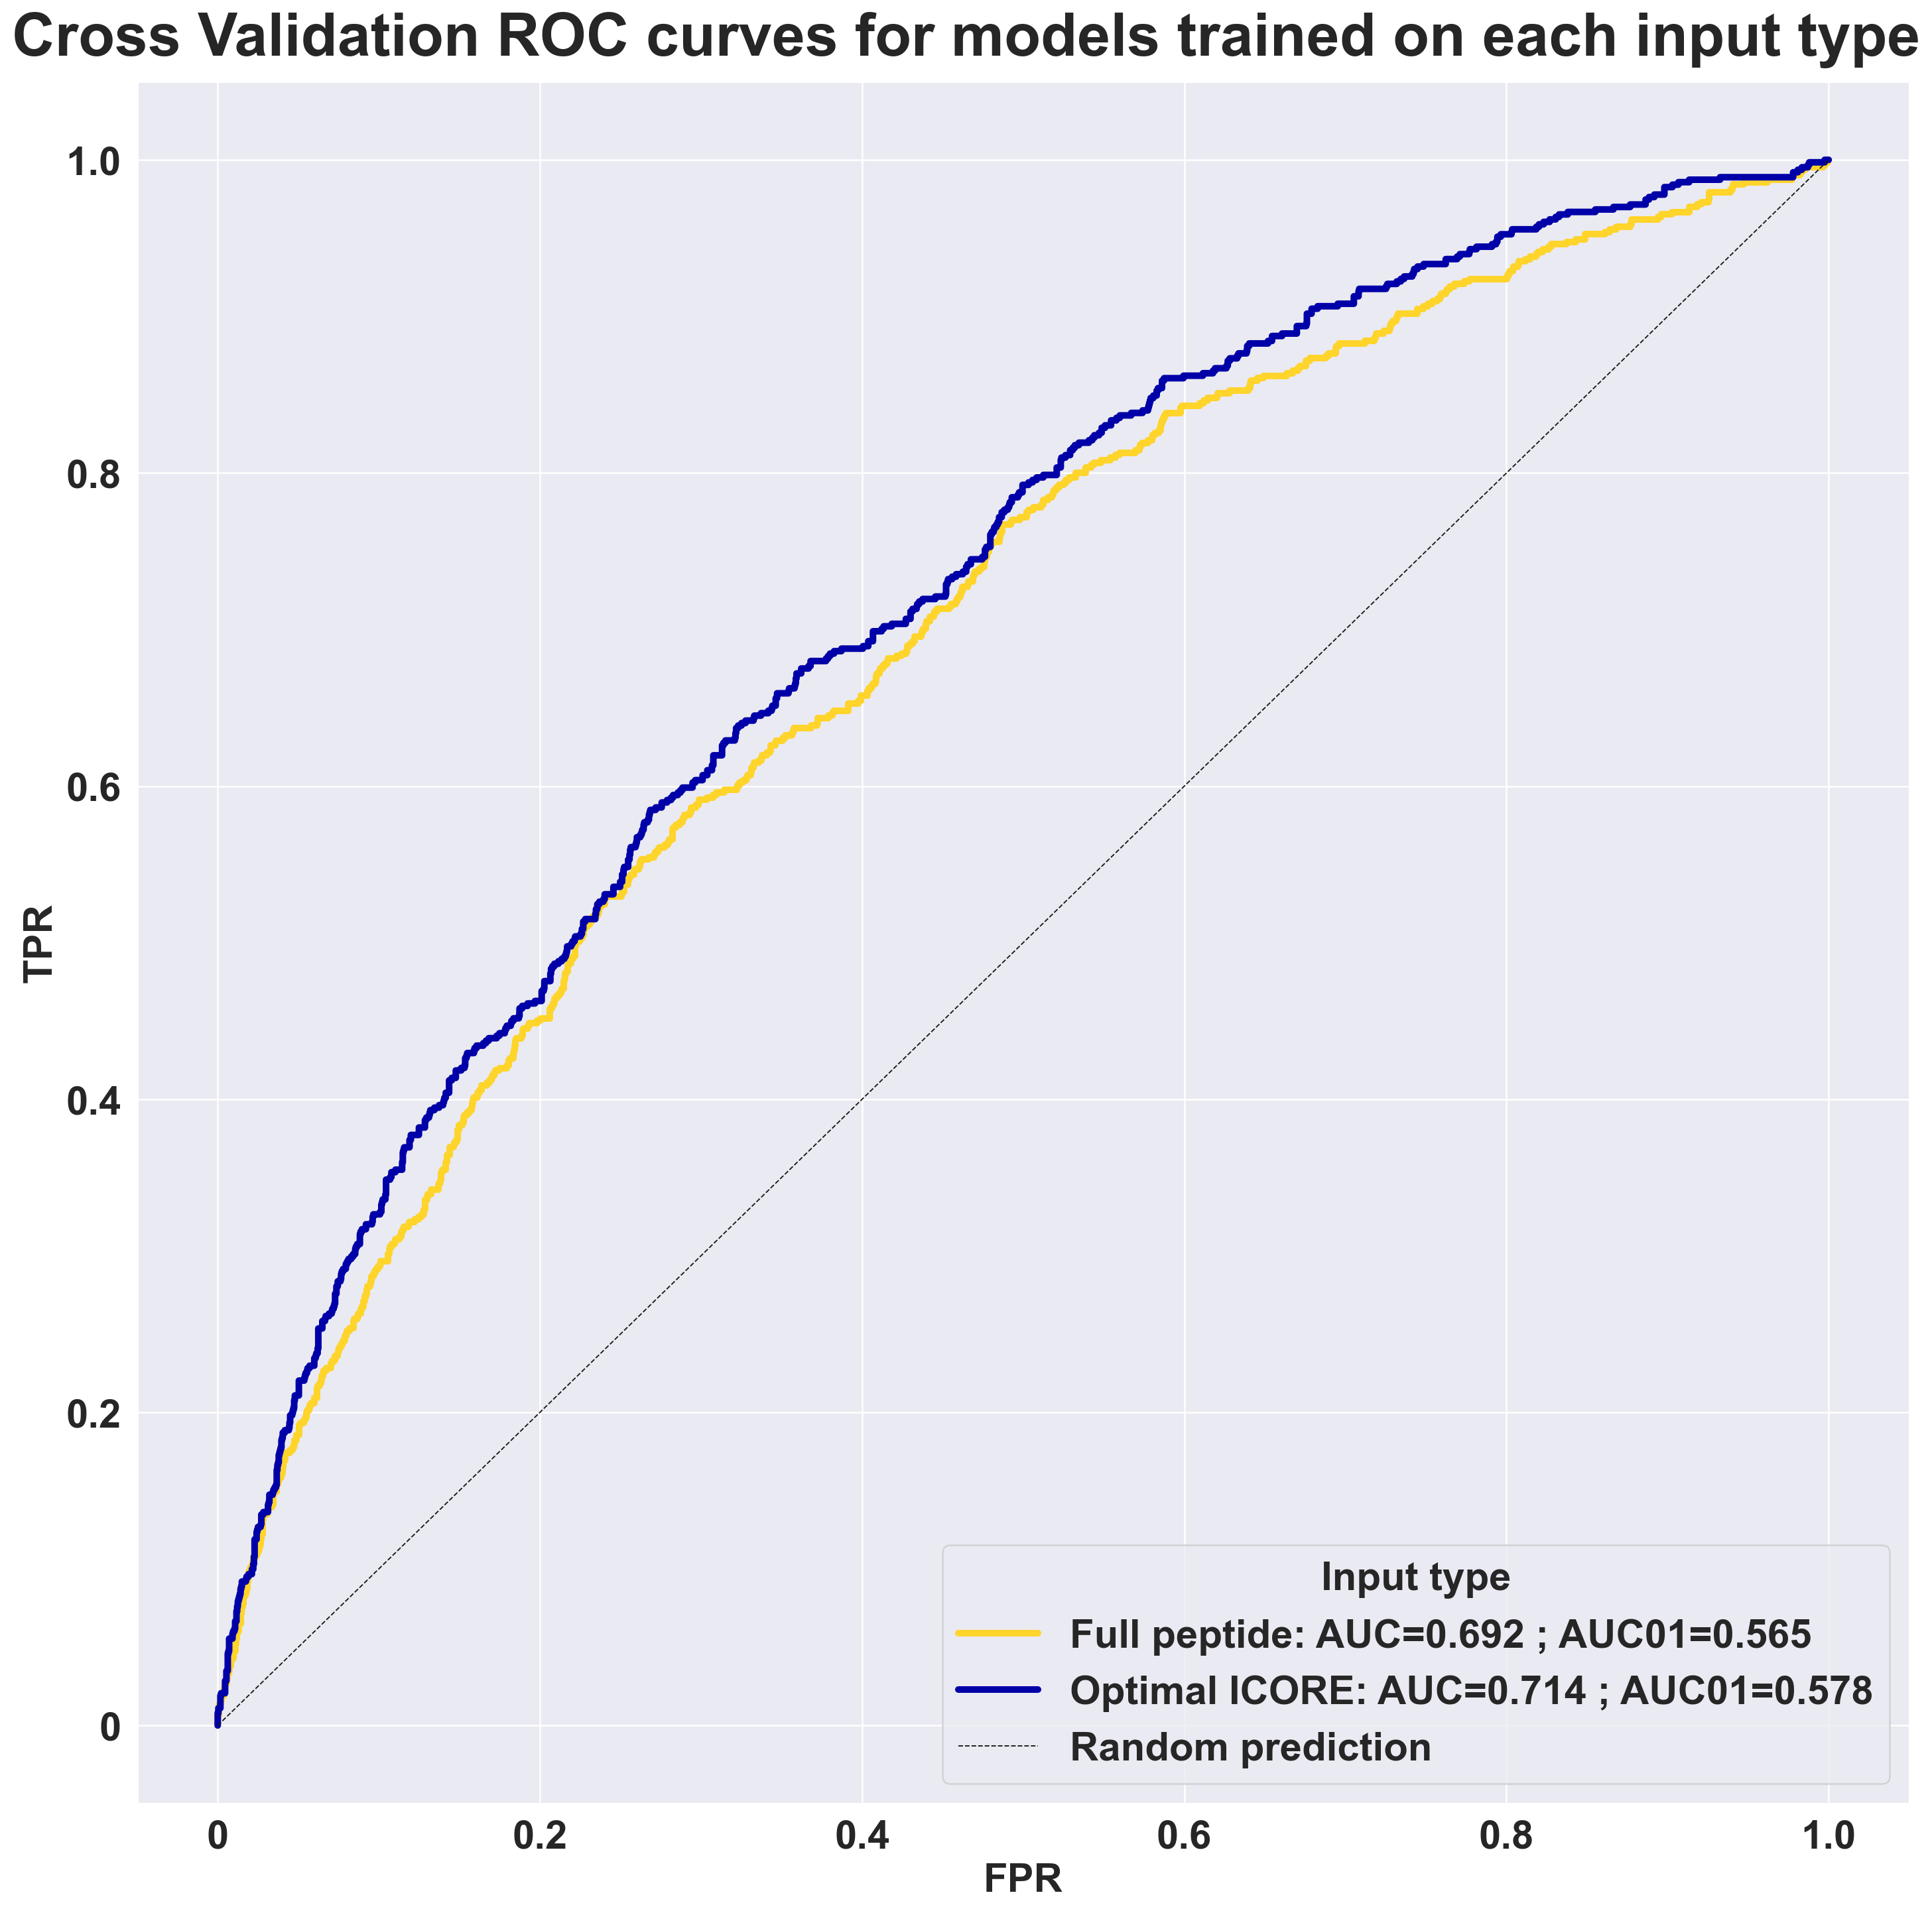

In [72]:
### ROC curve fig using fullpep rank vs icore rank
from sklearn.metrics import roc_auc_score, roc_curve
cedar_aligned = pd.read_csv('../data/aligned_icore/230418_cedar_aligned.csv')
f,a = plt.subplots(1,1, figsize=(16,16))
sns.set_style('darkgrid')
sns.set_palette(get_palette('gnuplot2_r', 2))

for k,v in results.items():
    fpr, tpr = results[k]['roc_curve']
    auc, auc_01 = results[k]['auc'], results[k]['auc_01']
    name = {'FullPep + Pep%Rank': 'Full peptide', 'optICORE + optICORE %Rank':'Optimal ICORE'}[k]
    sns.lineplot(x=fpr, y=tpr, estimator=None, lw=4, 
                 label=f'{name}: AUC={auc:.3f} ; AUC01={auc_01:.3f}', ax=a)
    
a.plot([0,1], [0,1], ls = '--', lw=0.75, label='Random prediction', c='k')
a.legend(title='Input type', loc='lower right', prop=dict(weight='bold', size=24), 
         title_fontproperties={'weight':'semibold', 'size':24})
a.set_xlabel('FPR', fontweight='semibold', fontsize=24)
a.set_xticklabels([-.2, 0, 0.2, 0.4, .6, .8, 1.0], fontweight='bold', fontsize=24)
a.set_ylabel('TPR', fontweight='semibold', fontsize=24)
a.set_yticklabels([-.2, 0, 0.2, 0.4, .6, .8, 1.0], fontweight='bold', fontsize=24)
f.suptitle('Cross Validation ROC curves for models trained on each input type', fontweight='bold', fontsize=36, ha= 'center', va= 'center')
f.tight_layout(pad=0.6)
f.savefig('../../../meetings/poster/2309XX_ElixirDenmark/ROC_curve_models.png', dpi=600, bbox_inches='tight')

## Redo Viral figure

In [75]:
viral_df = pd.read_csv('../../CEDAR_OUTPUTS//230401_viral_featimp_sampling_interative/feat_imps_df.csv')

In [80]:
viral_df.replace({'Inverted-Shannon':'Inv-KL'}, inplace=True)
viral_df.Weight.unique()

array(['Inv-KL', 'Mask', 'None'], dtype=object)

In [81]:
viral_df = viral_df.query('not Weight.str.contains("KL")')
viral_df.replace({'Mask':'IC-Masking'},inplace=True)

In [82]:
viral_df['Proportion Viral'] = viral_df.apply(lambda x: f"{x['ProportionViral']/100:.1%}", axis=1)
viral_df['Tryptophan (W) Feat. Importance'] = viral_df.apply(lambda x: 100*x['W'], axis=1)
viral_df.groupby(['Proportion Viral', 'Weight']).agg(mean_W_imp=('W','mean'))

mean_W_imp
Proportion Viral Weight                
0.0%             IC-Masking    0.020621
                 None          0.016073
16.7%            IC-Masking    0.024851
                 None          0.019612
23.1%            IC-Masking    0.028777
...                                 ...
81.5%            None          0.071188
81.8%            IC-Masking    0.081244
                 None          0.071505
9.1%             IC-Masking    0.022764
                 None          0.018023

[92 rows x 1 columns]

In [1332]:
sns.set_style('darkgrid')

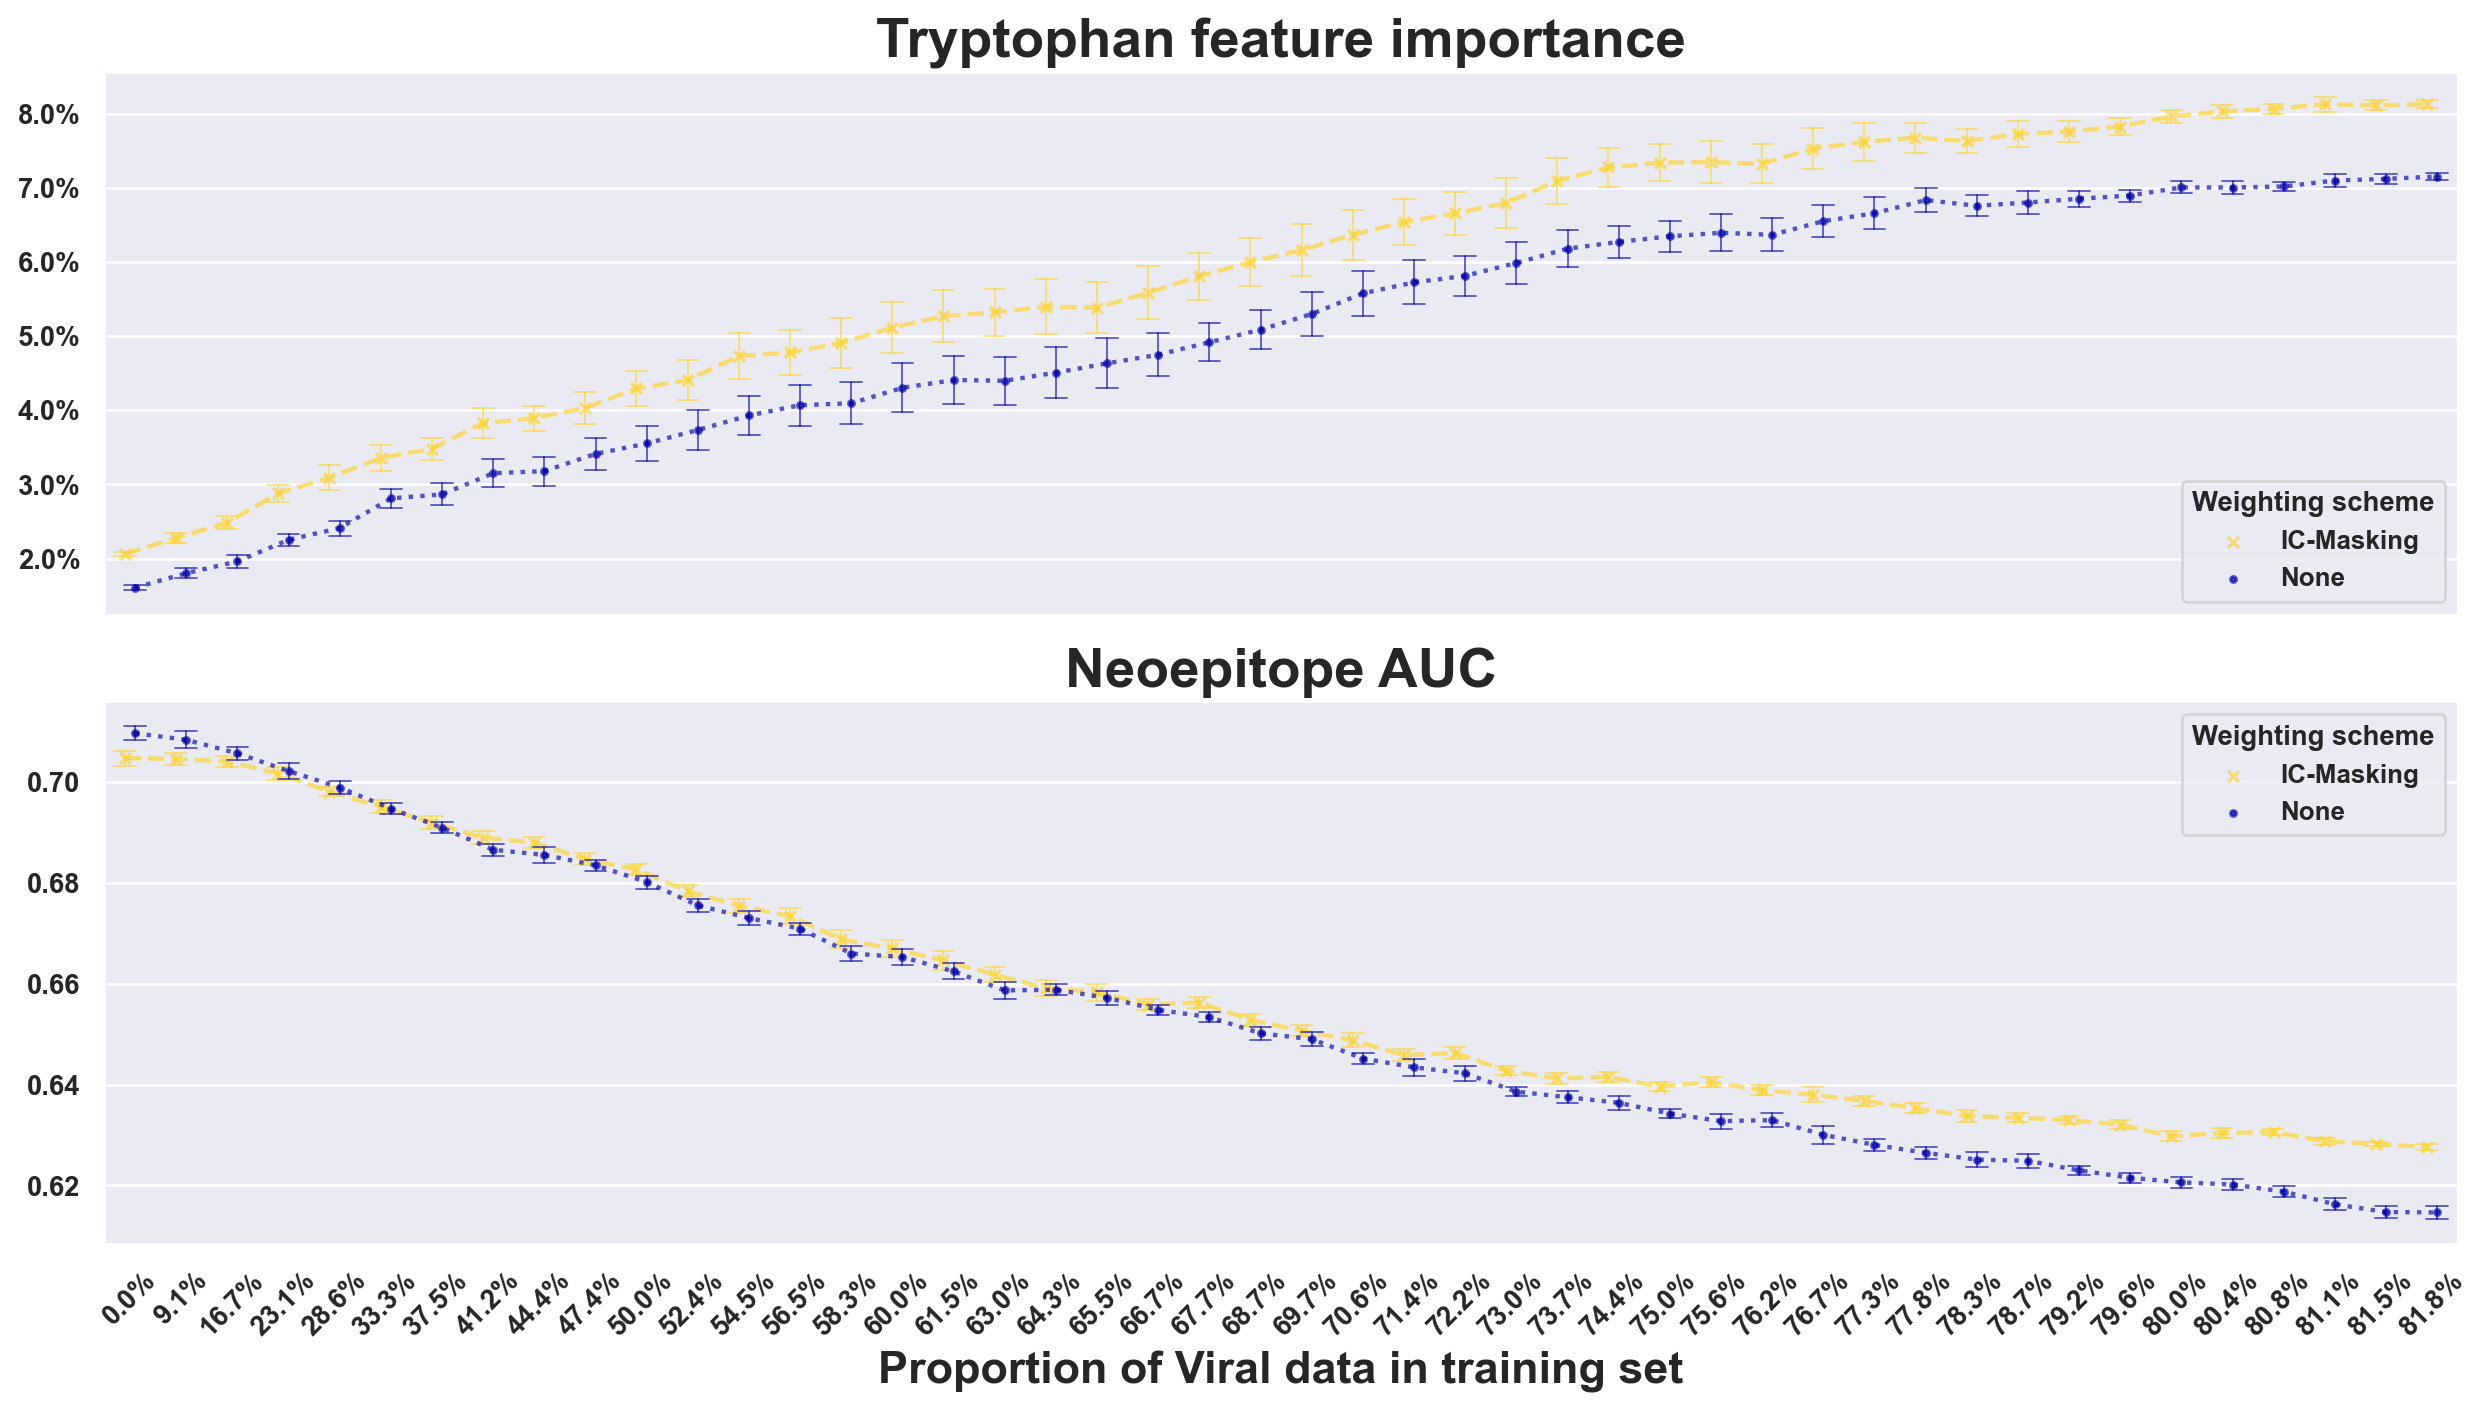

In [123]:
from src.utils import get_palette
f_viral,a = plt.subplots(2,1, figsize=(14,8), sharex=True)
a = a.ravel()
sns.set_palette(get_palette('gnuplot2_r', 2))
viral_df['PropViral'] = viral_df['Proportion Viral'].apply(lambda x: float(x[:-1]))
sns.pointplot(data=viral_df, x='Proportion Viral', y = 'Tryptophan (W) Feat. Importance', hue='Weight', ax=a[0], 
              errorbar='se', estimator='mean', errwidth=.7, capsize=.425, dodge=0.2, scale=0.65,
              markers=['x','.','*'], linestyles=['--',':','-.'])
plt.setp(a[0].patches, alpha=0.75)
plt.setp(a[0].lines, alpha=0.65)
plt.setp(a[0].collections, alpha=0.65)

sns.pointplot(data=viral_df, x='Proportion Viral', y = 'neoepi_auc', hue='Weight', ax=a[1], 
              errorbar='se', estimator='mean', errwidth=.7, capsize=.425, dodge=0.2, scale=0.65,
              markers=['x','.','*'], linestyles=['--',':','-.'])

plt.setp(a[1].patches, alpha=0.75)
plt.setp(a[1].lines, alpha=0.65)
plt.setp(a[1].collections, alpha=0.65)
a[1].legend(title='Weighting scheme', title_fontproperties=dict(size=11, weight='semibold'), loc='upper right', prop={'weight':'semibold', 'size':10.4})#,frameon=False)
a[0].legend(title='Weighting scheme', title_fontproperties=dict(size=11, weight='semibold'), loc='lower right', prop={'weight':'semibold', 'size':10.4})
a[0].set_xlabel('')
a[1].set_xlabel('Proportion of Viral data in training set', fontweight='semibold',fontsize=18)


a[1].set_xticklabels(a[1].get_xticklabels(), rotation=45, ha='center', va='top', fontweight='semibold')

vals = a[0].get_yticks()
a[0].set_yticklabels([f'{x}%' for x in vals], fontweight='semibold', fontsize=20);
a[1].set_yticklabels([f'{x:.2f}' for x in a[1].get_yticks()], fontweight='semibold', fontsize=20);
a[0].set_ylabel('')#a[0].get_ylabel(), fontweight='semibold')
a[1].set_ylabel('')#a[1].get_ylabel(), fontweight='semibold')

a[0].set_title('Tryptophan feature importance', fontweight='semibold', fontsize=22)
a[1].set_title('Neoepitope AUC', fontweight='semibold', fontsize=22)
f_viral.tight_layout()
f_viral.savefig('../../../meetings/poster/2309XX_ElixirDenmark/viral_importance', bbox_inches='tight', dpi=600)

## Featimp

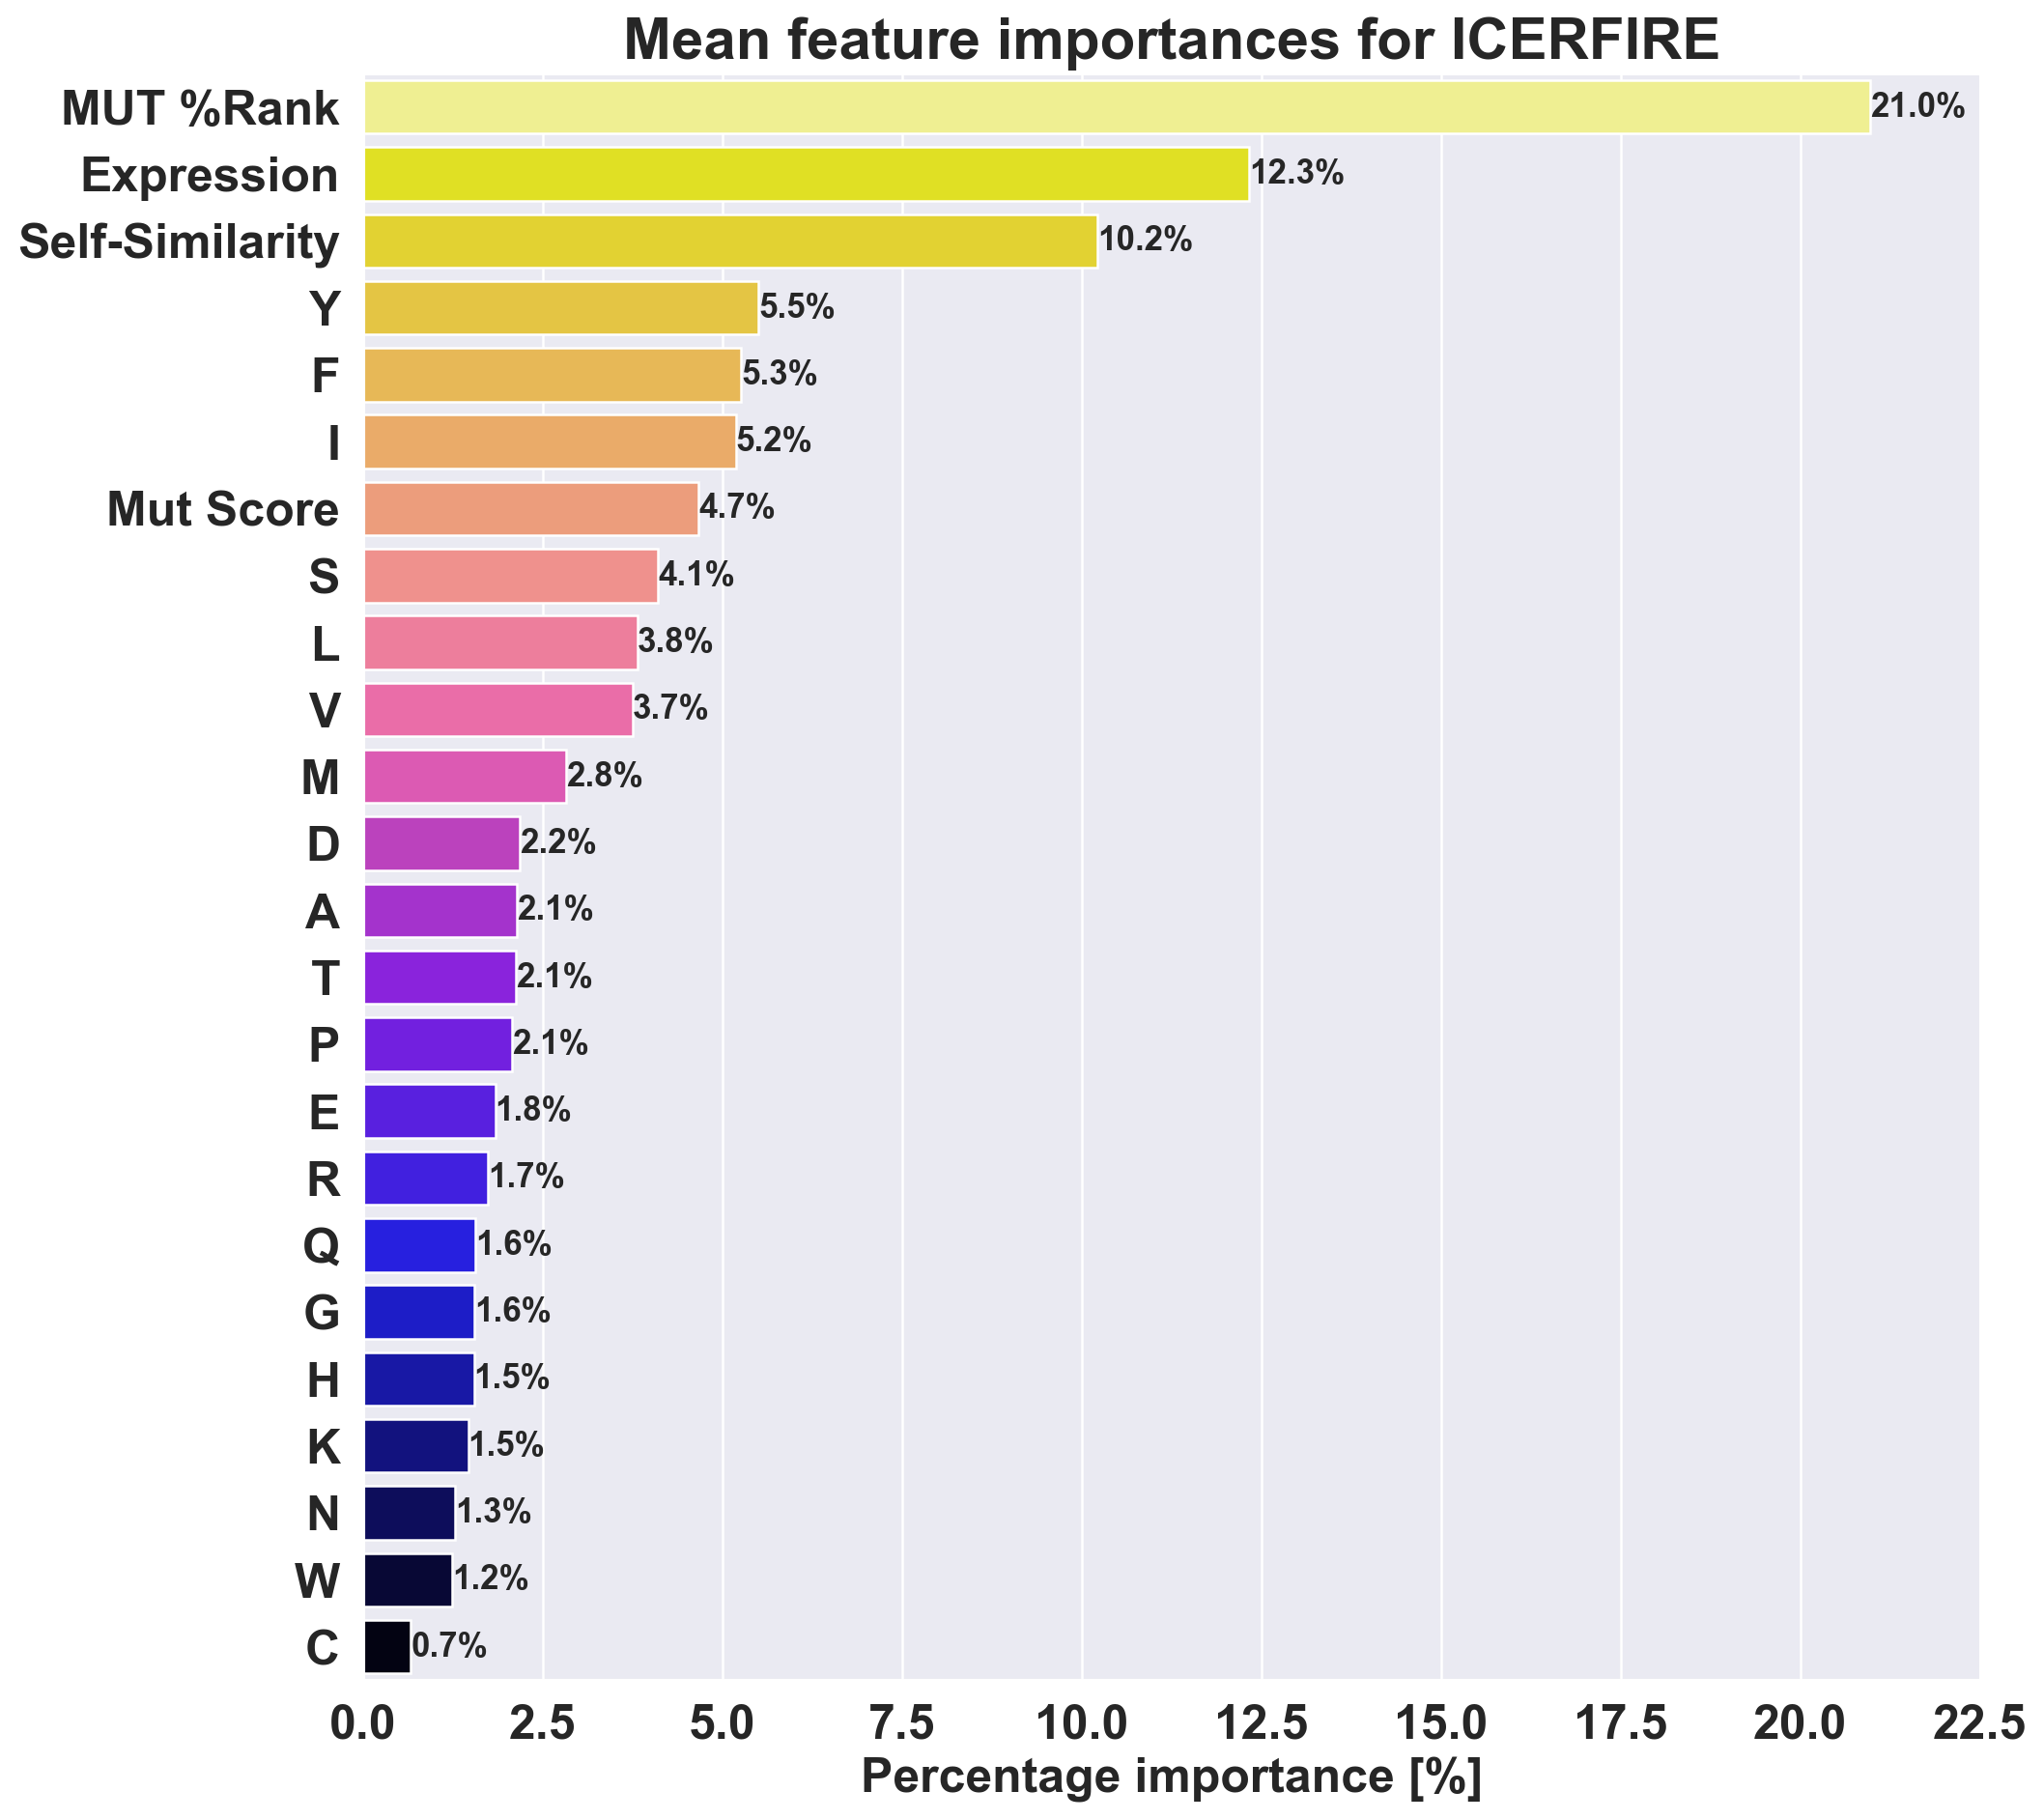

In [100]:
def get_fi(fn_dict, key, pdir='../../CEDAR_OUTPUTS//230427_FINAL_ANALYSIS_ALL/raw/'):
    fn = f"featimps_{fn_dict[key]}.csv"
    return pd.read_csv(f'{pdir}{fn}')
base_model = 'cedar_onehot_None_icore_mut_only_rank'
best_cedar = 'cedar_onehot_Inv-KL_icore_mut_boman-blsm_mut_score-EL_rank_wt_aligned-foreignness_score-Total_Gene_TPM'
best_prime = 'cedar_onehot_KL-Mask_icore_mut_dissimilarity_score-blsm_mut_score-ratio_rank-Total_Gene_TPM'
harmonic = 'cedar_onehot_KL-Mask_icore_mut_dissimilarity_score-blsm_mut_score-Total_Gene_TPM'
compromise = 'cedar_onehot_None_icore_mut_dissimilarity_score-blsm_mut_score-Total_Gene_TPM'
fn_dict = {'base_model':base_model, 'best_cedar':best_cedar, 'best_prime':best_prime, 'harmonic':harmonic, 'compromise':compromise}
def rename(col):
    d = {'icore_boman':'Boman Index',
         'icore_blsm_mut_score':'Mut Score',
         'EL_rank_wt_aligned': 'WT %Rank',
         'rank': 'MUT %Rank',
         'foreignness_score': 'Foreignness',
         'Total_Gene_TPM' : 'Expression',
         'icore_dissimilarity_score':'Self-Similarity',
         'ratio_rank': 'Agretopicity'}
    if col in d.keys():
        return d[col]
    else:
        return col
fi_harmonic = get_fi(fn_dict, 'harmonic')
# Remaking bigger, only harm here
from src.metrics import plot_feature_importance
f,a = plt.subplots(1,1, figsize=(12,12))

                        
plot_feature_importance(fi_harmonic.values.flatten(), 
                        list(map(rename,fi_harmonic.columns)), 
                        palette='gnuplot2_r', ax=a, 
                        label_number=True)
a.set_ylabel('')
a.set_xlabel('Percentage importance [%]', fontsize=20, fontweight='semibold')
a.set_yticklabels(a.get_yticklabels(), fontsize=20, fontweight='semibold')
a.set_xticklabels(a.get_xticklabels(), fontsize=20, fontweight='semibold')
a.set_title('Mean feature importances for ICERFIRE', fontweight='bold', fontsize=24)
a.set_xlim([0.,0.225])
f.savefig('../../../meetings/poster/2309XX_ElixirDenmark/featimps.png', bbox_inches='tight', dpi=600)

## bench

In [127]:
bench.Model.unique()

array(['AXEL-F', 'PRIME', 'IEDB-Calis', 'NetMHCpan', 'HLAthena',
       'MHCflurry', 'NetMHCpanExp', 'ag.Foreignness', 'NNAlign',
       'Optimal CEDAR Model', 'Optimal PRIME Model', 'Harmonic Model',
       'Base Model'], dtype=object)

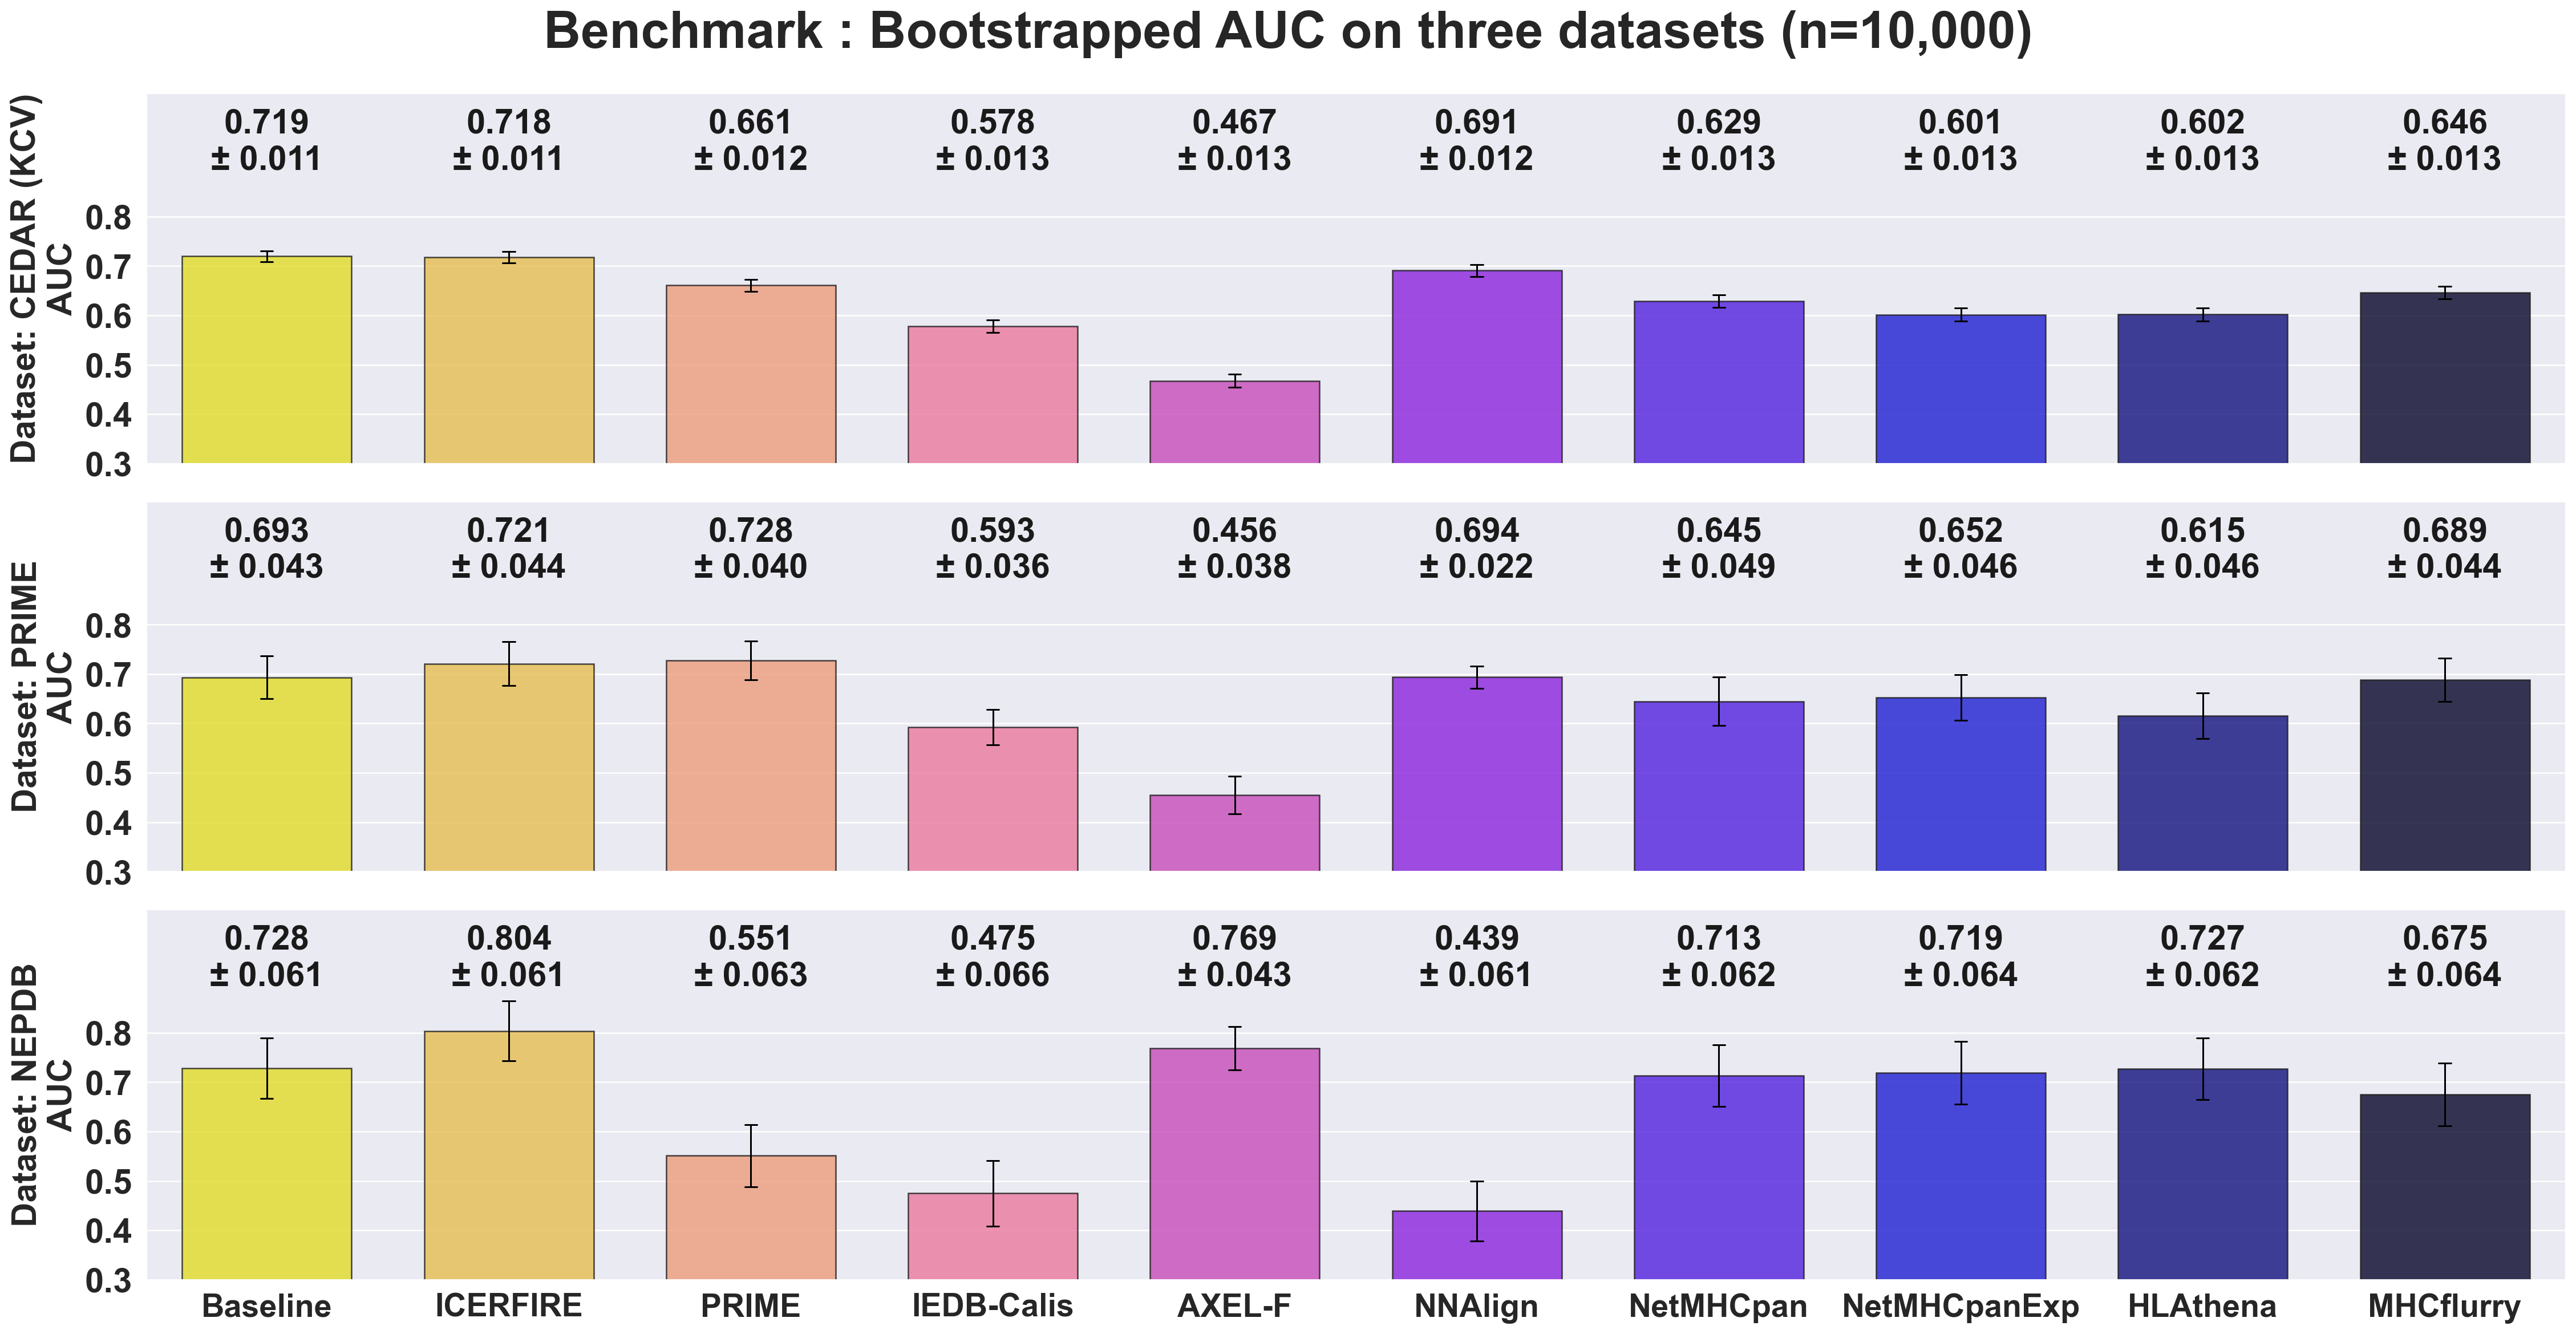

In [141]:
selected_models = ['Baseline', 'ICERFIRE', 'PRIME', 'IEDB-Calis', 'AXEL-F', 'NNAlign', 'NetMHCpan', 'NetMHCpanExp', 'HLAthena', 'MHCflurry']

colors = {k:v for k,v in zip(get_palette('gnuplot2_r', len(selected_models)), selected_models)}
sns.set_palette(get_palette('gnuplot2_r',len(selected_models)))
f1, a1 = plt.subplots(3,1, figsize=(25.25, 13), sharex=True)
a1 = a1.ravel()
bench.replace({'HLAthena_E':'HLAthena', 'NetMHCpan\nExp':'NetMHCpanExp'},inplace=True)
bench.rename(columns={'condition':'Model'}, inplace=True)
for evalset, axis in zip([ 'CEDAR', 'PRIME', 'NEPDB'], a1):
    tmp = bench.query('evalset==@evalset')
    sns.barplot(tmp, x='Model', y='auc', errorbar='sd', order = selected_models, ax=axis, width=0.7, capsize=.05, errwidth=1.2, errcolor='.0')
    plt.setp(axis.patches, edgecolor='k', linewidth=1., alpha=0.8)
    # axis.set_title(f'{evalset}', fontweight='bold', fontsize=14)
    name = f'Dataset: {evalset}'
    if evalset == 'CEDAR':
        name = name + ' (KCV)'
    name = name + '\nAUC'
    axis.set_ylabel(name, fontweight='bold', fontsize=24)
    axis.set_ylim([0.3,1.05])
    ticks = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    axis.set_yticks(ticks, labels =  [f'{x:.1f}' for x in ticks])
    axis.set_yticklabels(axis.get_yticklabels(),fontweight='bold', fontsize=24)
    # axis.set_yticklabels(#axis.get_yticklabels(),#[f'0.{x}' for x in range(10)],
    #                      ['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'], 
    #                      fontweight='bold', fontsize=24)
    add_vertical_label(tmp, selected_models, 'auc', axis, height= .95, fontweight='bold', fontsize=24)
a1[0].set_xlabel('')
a1[1].set_xlabel('')
a1[2].set_xlabel('', fontweight='bold', fontsize=24)
a1[2].set_xticklabels(a1[2].get_xticklabels(), ha='center', fontweight='semibold', fontsize=22.3)
f1.suptitle('Benchmark : Bootstrapped AUC on three datasets (n=10,000)', fontweight='bold', fontsize=36, ha= 'center', va= 'center')
f1.tight_layout()
f1.savefig('../../../meetings/poster/2309XX_ElixirDenmark/benchmark_top', dpi=600, bbox_inches='tight')


In [ ]:

# Here remake the horizontal plot with only AUC (and not AUC 01, so single panel)
# MEAN HORIZONTAL BARPLOTS
f_bot,a_bot = plt.subplots(1,1, figsize=(20, 7.5), sharex=True)
sns.set_theme()
sns.set_style('darkgrid')
sns.set_palette(get_palette('gnuplot2_r', len(selected_models)))

tmp_pivot = pivot_gb.reset_index().replace({'Base Model': 'Baseline','Harmonic Model':'ICERFIRE'}).set_index('Model')
sns.barplot(tmp_pivot.reset_index(), y='Model', x='mean_auc',ax=a_bot, 
            xerr = tmp_pivot.reindex(selected_models)['std_auc'], errorbar=None,
            error_kw={'capsize':2, 'capthick': .75, 'linewidth':.75,}, order = selected_models)


plt.setp(a_bot.patches, edgecolor='k',  linewidth= 1., alpha=0.8)

a_bot.set_ylabel('', fontweight='bold', fontsize=24)
a_bot.set_yticklabels(a_bot.get_yticklabels(), fontweight='bold',fontsize=24)
a_bot.set_xlim([0, .9])
a_bot.set_xlabel('Mean AUC', fontweight='bold', fontsize=24)
a_bot.set_xticklabels([f'0.{x}' for x in range(10)], fontweight='bold', fontsize=24)
add_horizontal_label(tmp_pivot, selected_models, 'auc', a_bot, length=.85, fontsize=24, fontweight='bold')
# add_horizontal_label(pivot_gb, selected_models, 'auc01', a2[1], length=.85)
f_bot.tight_layout()
f_bot.savefig('../../../meetings/poster/2309XX_ElixirDenmark/benchmark_bot.png', 
              dpi=600, bbox_inches='tight')
